# GANによる画像生成のメカニズムとDCGANの実装

commit用

```mycode/5_gan_generation/```

In [1]:
!pip list | grep scikit

scikit-image                            0.15.0             
scikit-learn                            0.21.3             


In [2]:
!gpustat

/bin/sh: gpustat: command not found


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [4]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
%config IPCompleter.greedy=True

## 5-1 GANによる画像生成のメカニズムとDCGANの実装

### Generatorのメカニズム
Generatorは入力乱数から目的の画像を生成するのでデータの次元を拡大していく必要がある．
このときに重要になるのが**転置畳み込み**である．
普通の畳み込みは入力データの全てのセルとカーネルの全てのセルの計算結果を集約して１つのセルにするのに対して，転置畳み込みは１つの入力セルに対して全てのカーネルのセルを作用させてその１つ１つを出力とするので結果として出力されるデータの次元は大きくなる．

### Generatorの実装
本節ではGANの中でも特に**DCGAN**と呼ばれるものを実装する．

***DCGAN：***Deep Convolution Generative Adversarial Network

実装に当たって入力する乱数の次元を```z_dim=20```にしてるがこれには特に意味はなく，生成画像の多様性が担保されればなんでも良い


In [7]:
class Generator(nn.Module):
    
    def __init__(self, z_dim = 20, image_size=64):
        super(Generator, self).__init__()
        
        # ここで out_channels = image_size*8に特別な意味は？
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size*8, kernel_size=4, stride=1),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
            
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size*8, image_size*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size*4, image_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True))
              
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size*2, image_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh())
        # 白黒なので出力は1チャネル
        
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

torch.Size([1, 20, 1, 1])
--------------------
torch.Size([1, 1, 64, 64])


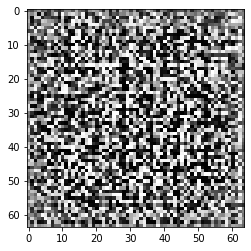

In [17]:
# 実装したネットワークで出力
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

input_z = torch.randn(1,20)

# テンソルを(1,20)から(1,20,1,1)に変形
# (batch_size, channel, H, W)
input_z = input_z.view(input_z.size(0), input_z.size(1),1,1)
print(input_z.size())

print("--------------------")

fake_images = G(input_z)
print(fake_images.size())

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed,'gray')
plt.show()

1
